# Project A4:  Concurrent Data Structures and Memory Coherence  
## 1. Introduction
The goal of this project is to explore how lock granularity and coherence traffic affect performance by comparing a simple coarse-grained design with a finer or atomic variant. 

## 2. Methodology

### 2.1 Experimental Environment

CPU: AMD Ryzen 5 7600X | 4691.105Mhz

6 physical cores, 2 threads per core(SMT)

Cache hierarchy:

L1d: 32 KB per core × 6

L1i: 32 KB per core × 6

L2: 1 MB per core × 6

L3: 32 MB shared

OS: Ubuntu 24.04.3 LTS

gcc: gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0

NUMA:       
             
NUMA node(s):           1

NUMA node0 CPU(s):      0-11

Flags: SSE, AVX, AVX2, AVX512, AVX512f

Pthread is used in this project

### 2.2 Setup & Measurement Method

For the data structure, I choose hash table.

**hash_baseline:**

I use chaining hash table, For each operation (insert, find, erase), the target bucket is located by bucket = hash(key) % nbuckets, and the linked list is traversed to search/update/remove the key.

**Correctness**

Thread safety tactic: a single global pthread_mutex_t guards the entire hash table.

acquire global lock -> perform bucket operation -> release the lock

This guarantees mutual exclusion across all threads and prevents data races on shared pointers and node memory. Deadlocks cannot occur in this version since only a single lock is ever acquired and released in a strict manner.

**hash_fine_grained:**

This is the upgraded version of baseline. All the fuctional behaviors(insert, find erase) are the same. 

**Correctness**

Thread safety tactic: this version allocates a lock array pthread_mutex_t bucket_locks[nbuckets], with one mutex per bucket.

For an operation on key k, the execution flow is as follows:

compute b = hash(k) % nbuckets -> acquire bucket_locks[b] -> traverse / update the linked list in bucket b -> release bucket_locks[b]

This allows operations targeting different buckets to proceed concurrently. Deadlocks are avoided because each operation acquires at most one lock, and releases it before returning, so there is no lock ordering problem.



**Metrics:**

Throughput(ops/s) : total operations / execution time

Speedup(T) : Throughput(T) / Throughput(1)

Due to the lack of hardware performance counter support in the WSL2 kernel, we are unable to collect cycles/ cache misses/ coherence using perf.

**Workloads**

1. lookup-only

2. insert-only

3. mixed 70/30

Repeats: 3

**Dataset sizes**

1e4, 1e5, 1e6 keys

**Thread scaling**

T = [1, 2, 4, 8, 12]

Run: 

In [ ]:
make

chmod +x thread_scaling.sh
./thread_scaling.sh ./hash_baseline ./hash_fine_grained exp1.csv

python3 plot_1.py exp1.csv

chmod +x data_size.sh
./data_size.sh ./hash_baseline ./hash_fine_grained exp2.csv

python3 plot_2.py


# 3. Results

## 3.1 Thread scaling

For this part, we fix the keys = 1e5, we repeat experiments 3 times.
### Lookup
| 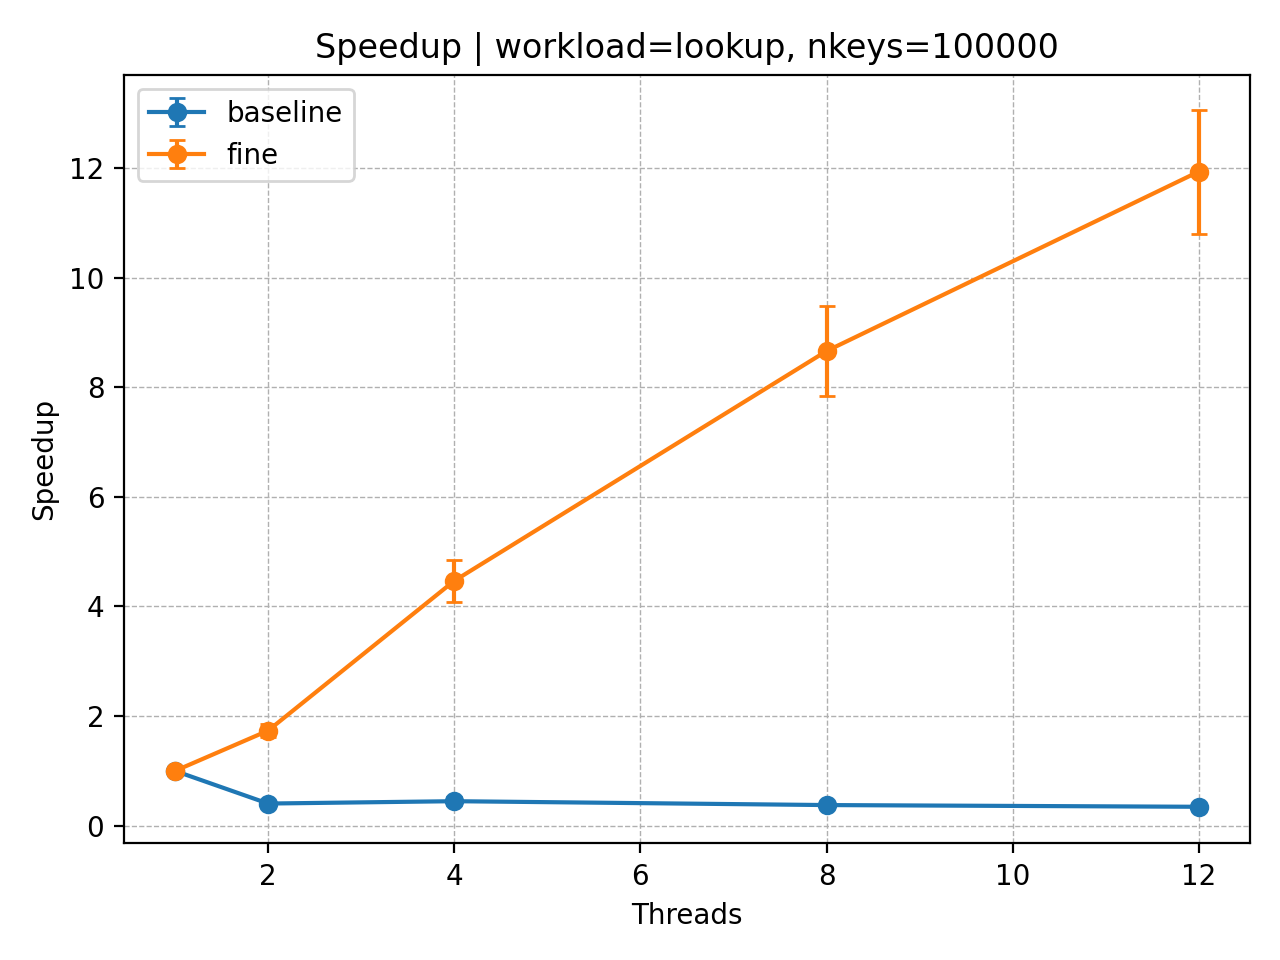 | 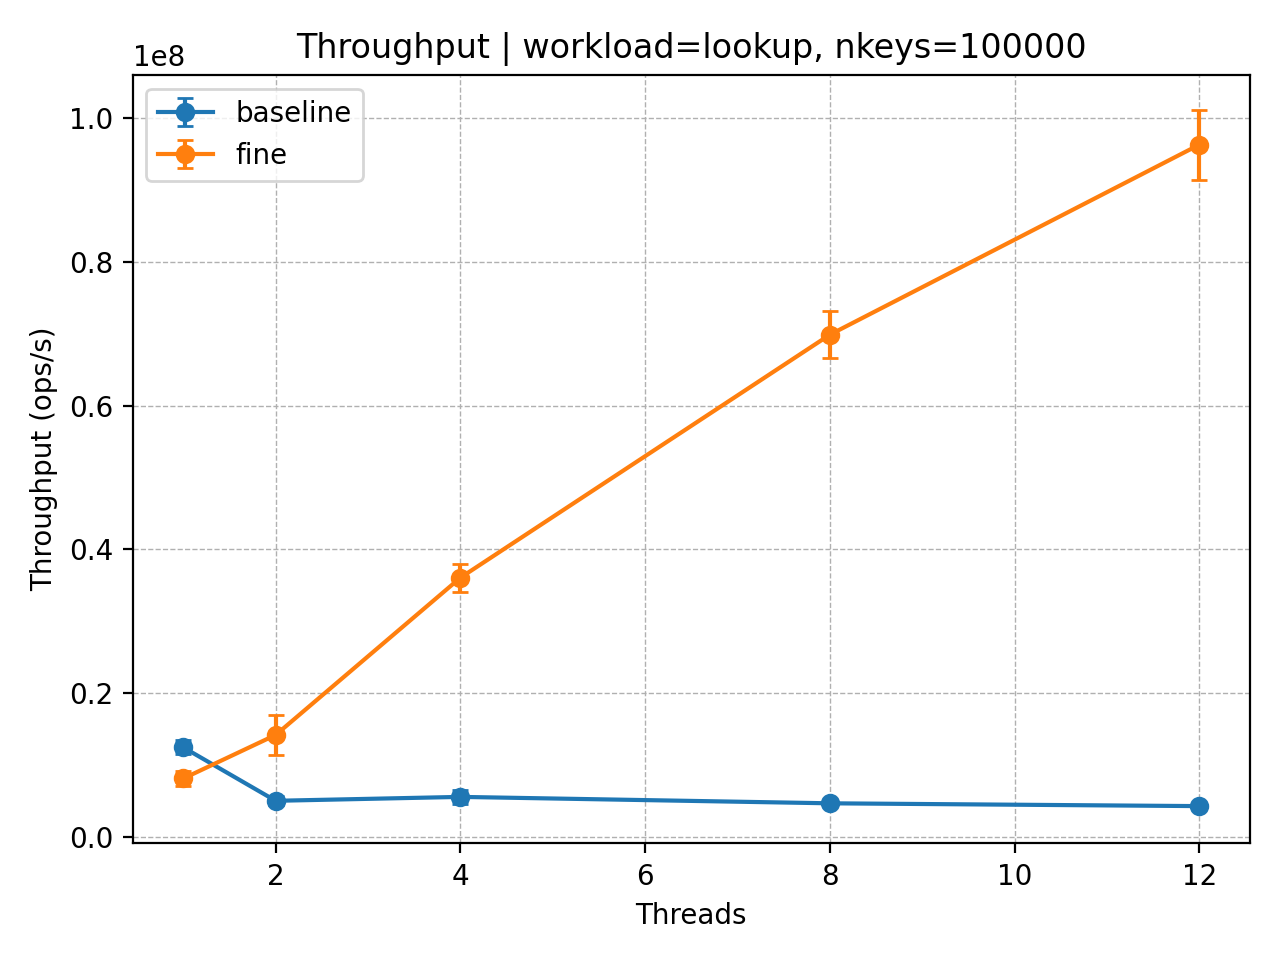|
|:----------------------------------------------------:|:----------------------------------:|

### Insert

| 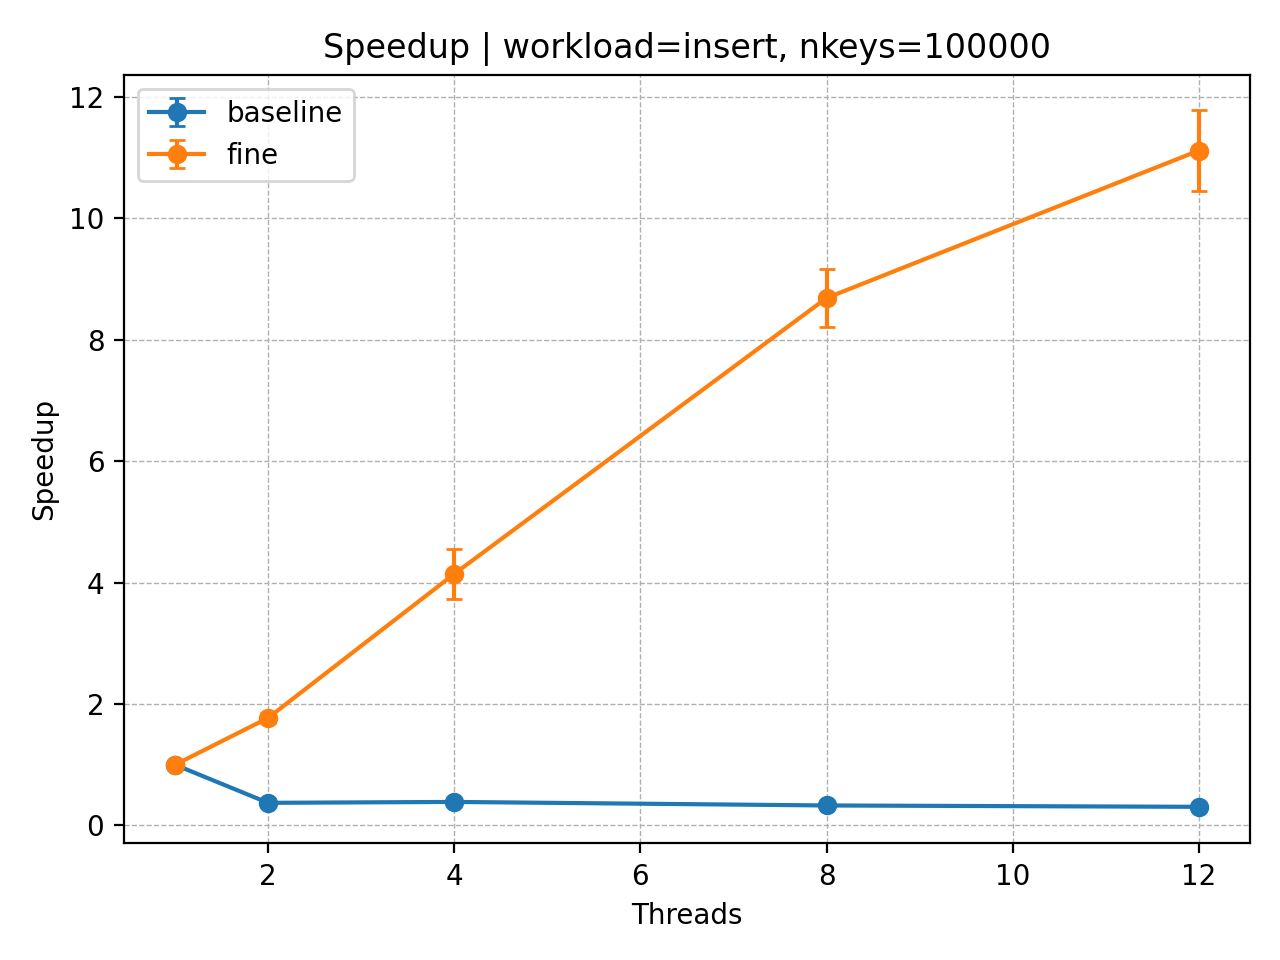 | 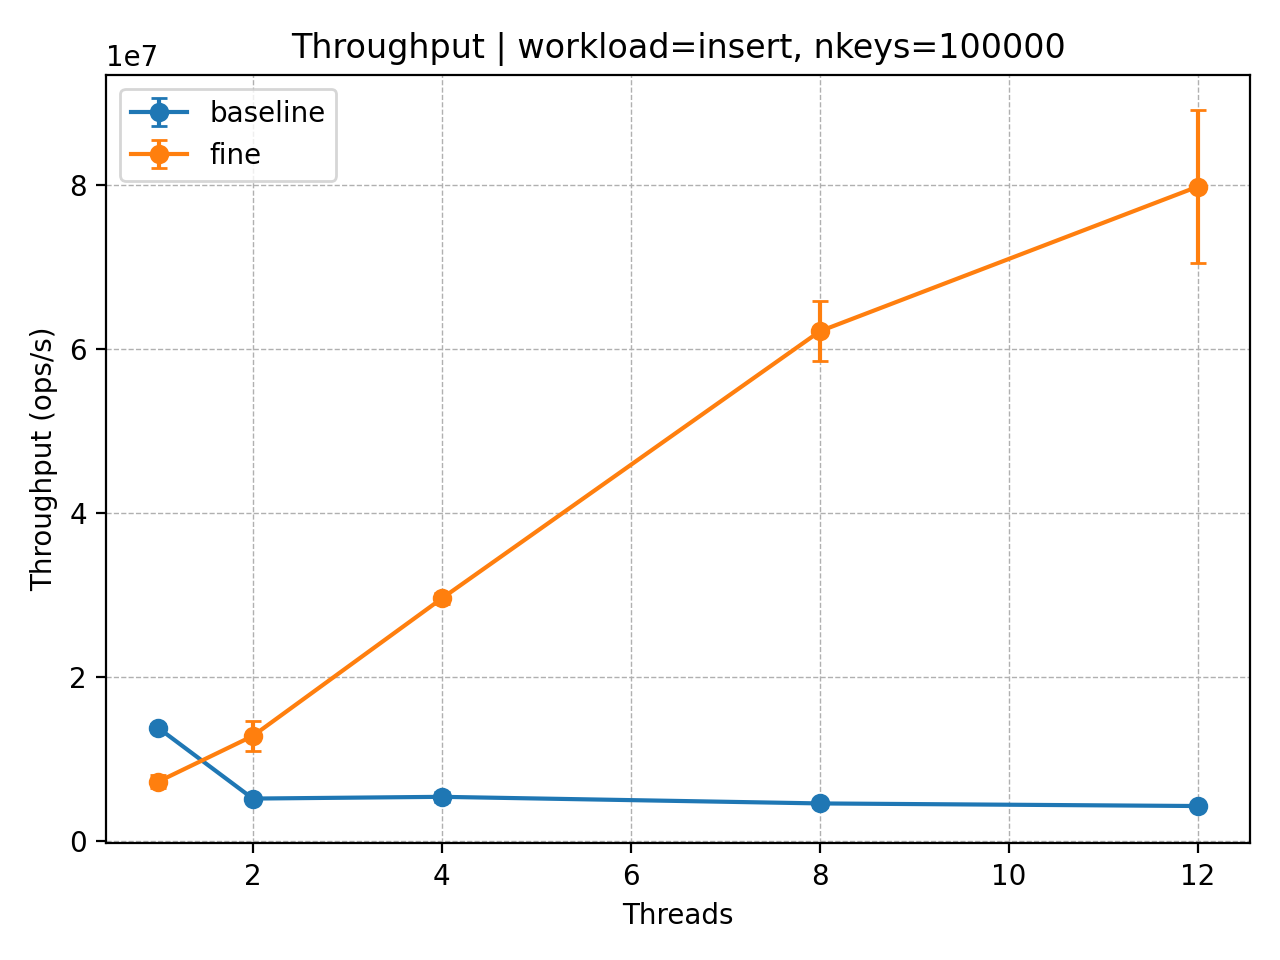|
|:----------------------------------------------------:|:----------------------------------:|

### Mix
| 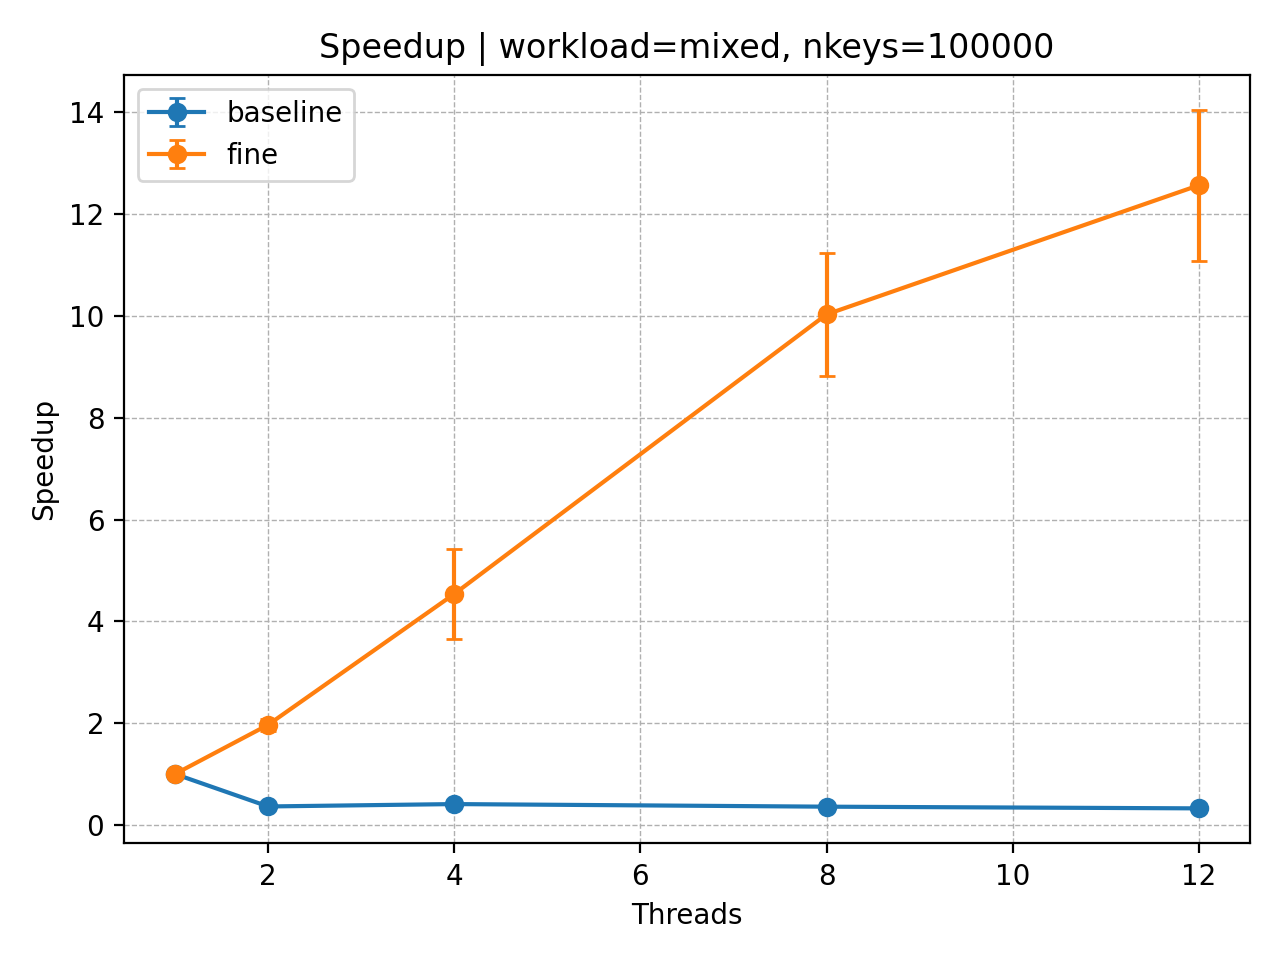 | 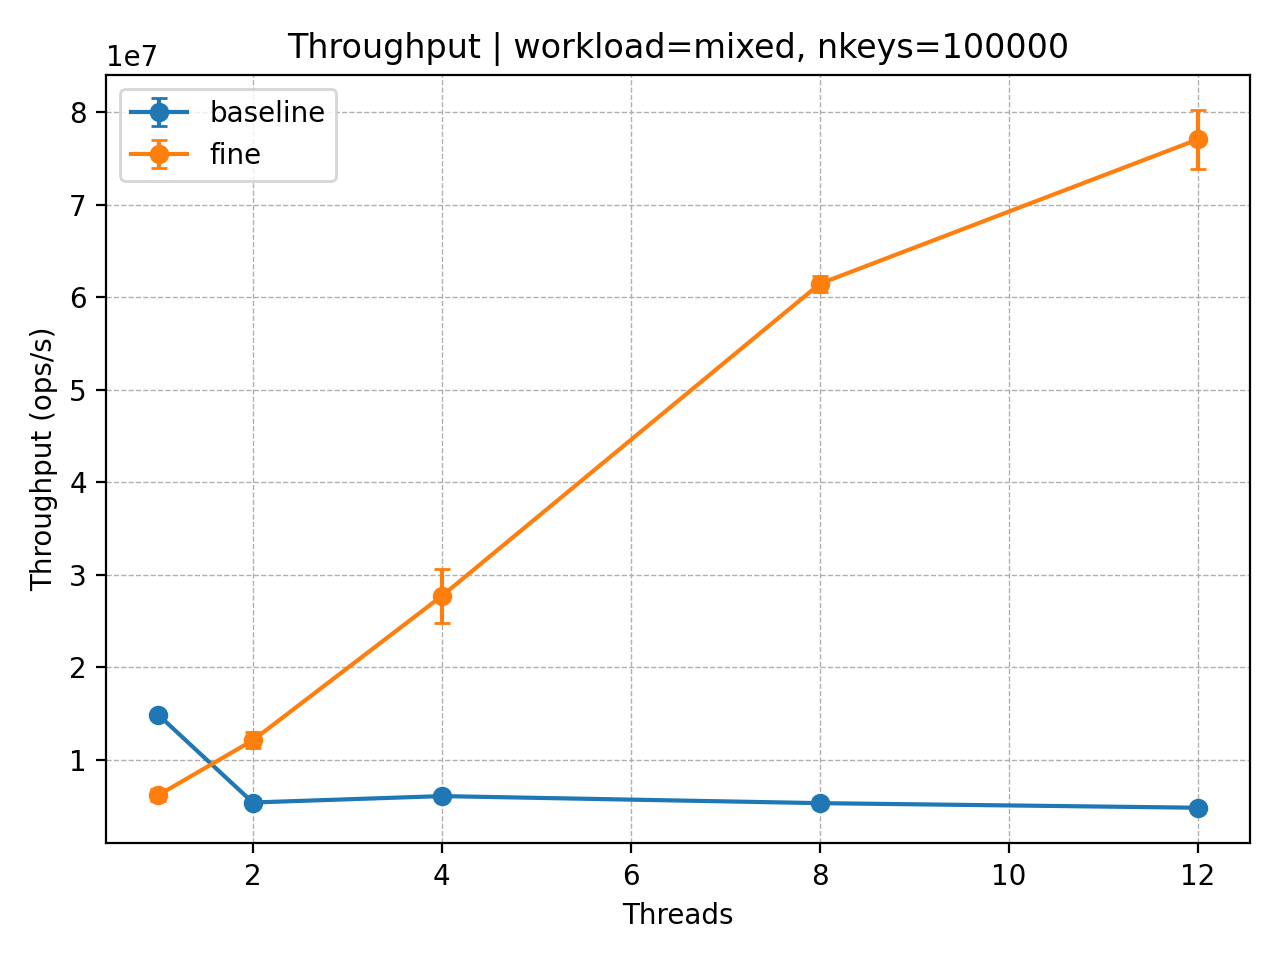|
|:----------------------------------------------------:|:----------------------------------:|

Across all three workloads, the coarse-grained baseline scales poorly. Throughput quickly saturates or even drops as more threads are added, and speedup stays well below one. This shows that the single global lock serializes operations and becomes a major bottleneck, regardless of the workload.

In contrast, the fine-grained locking design scales well in all cases. With per-bucket locks, operations on different buckets can run in parallel, so throughput increases steadily as thread count grows.

Scalability also depends on the workload type. The fine-grained design performs best for lookup-only workloads, followed by the mixed workload, while insert-only shows slightly weaker Overall, fine-grained synchronization delivers much better performance than coarse-grained locking under concurrent execution.

## 3.2 Data size 

For this part, we fix the thread = 12, we repeat experiments 3 times.

| 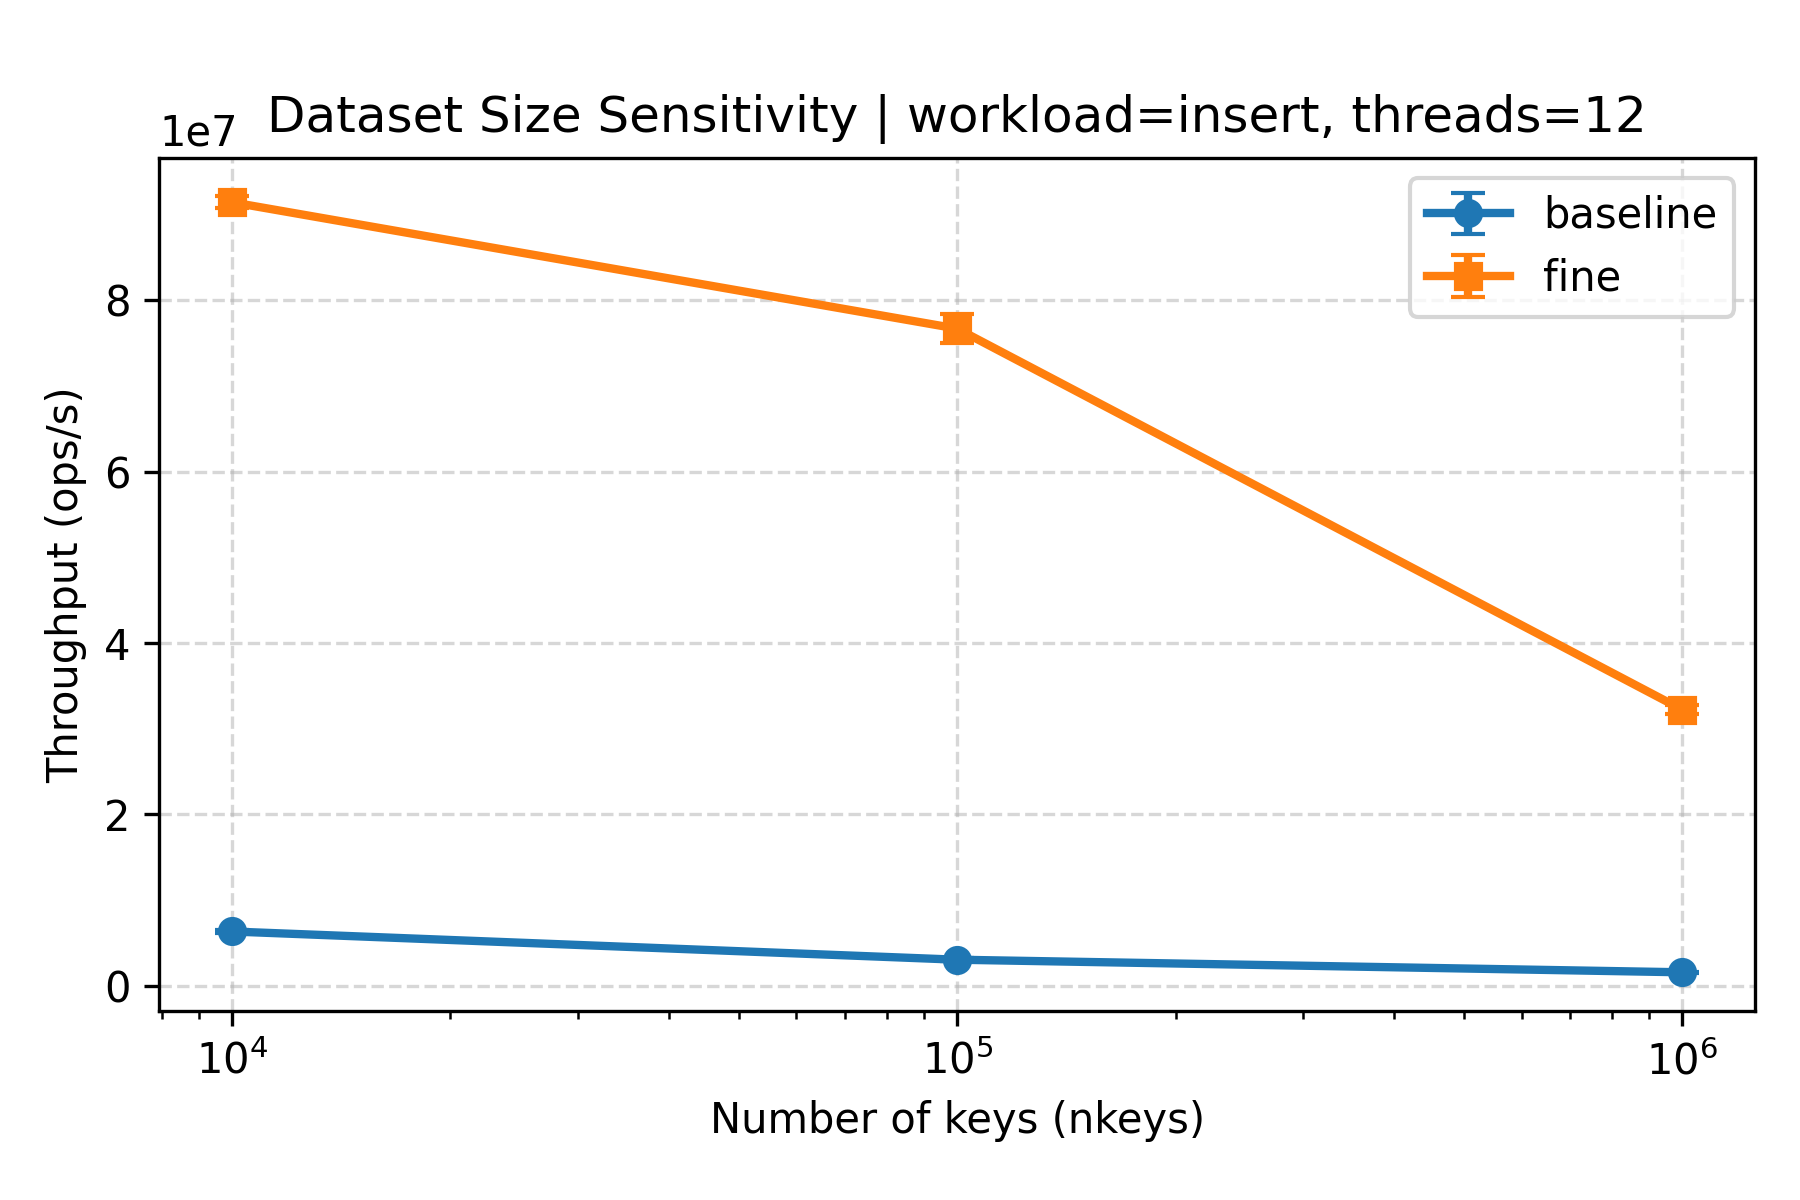 | 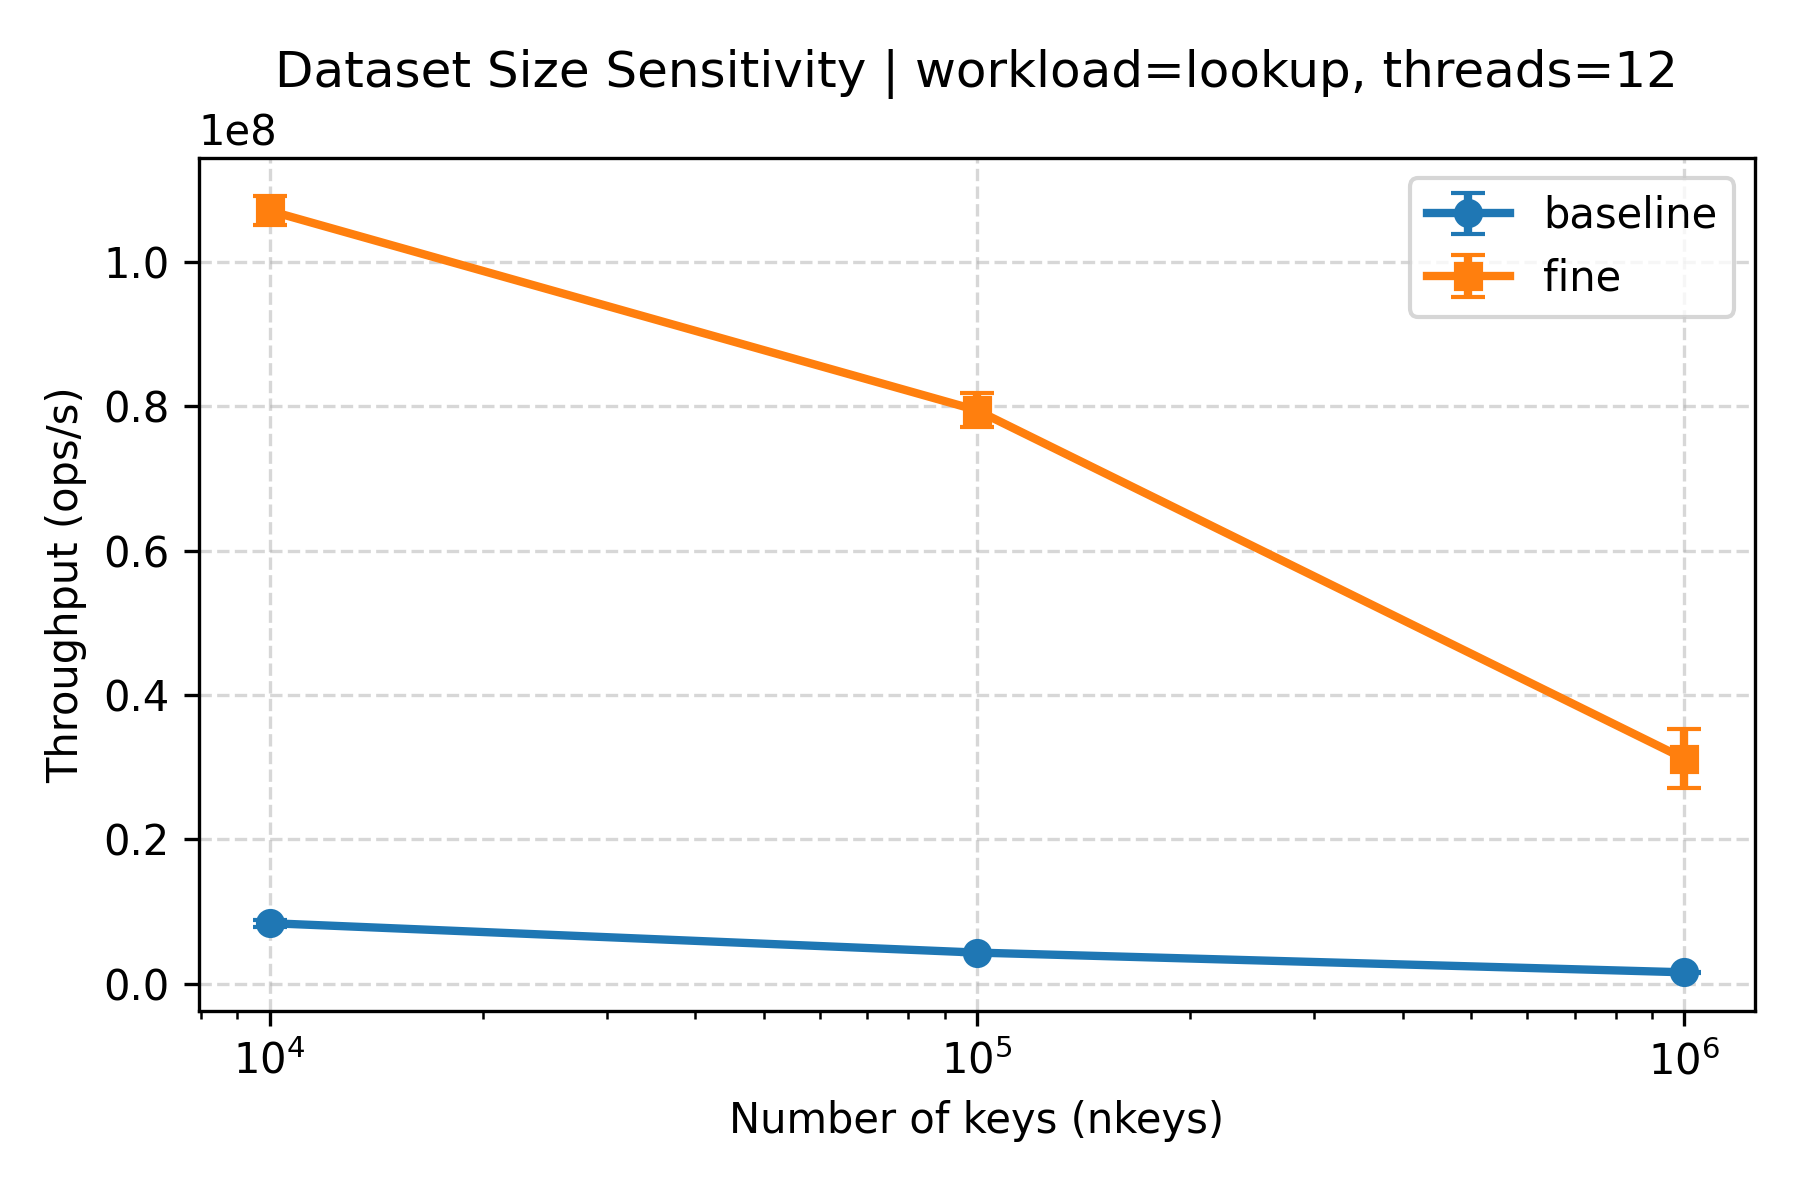|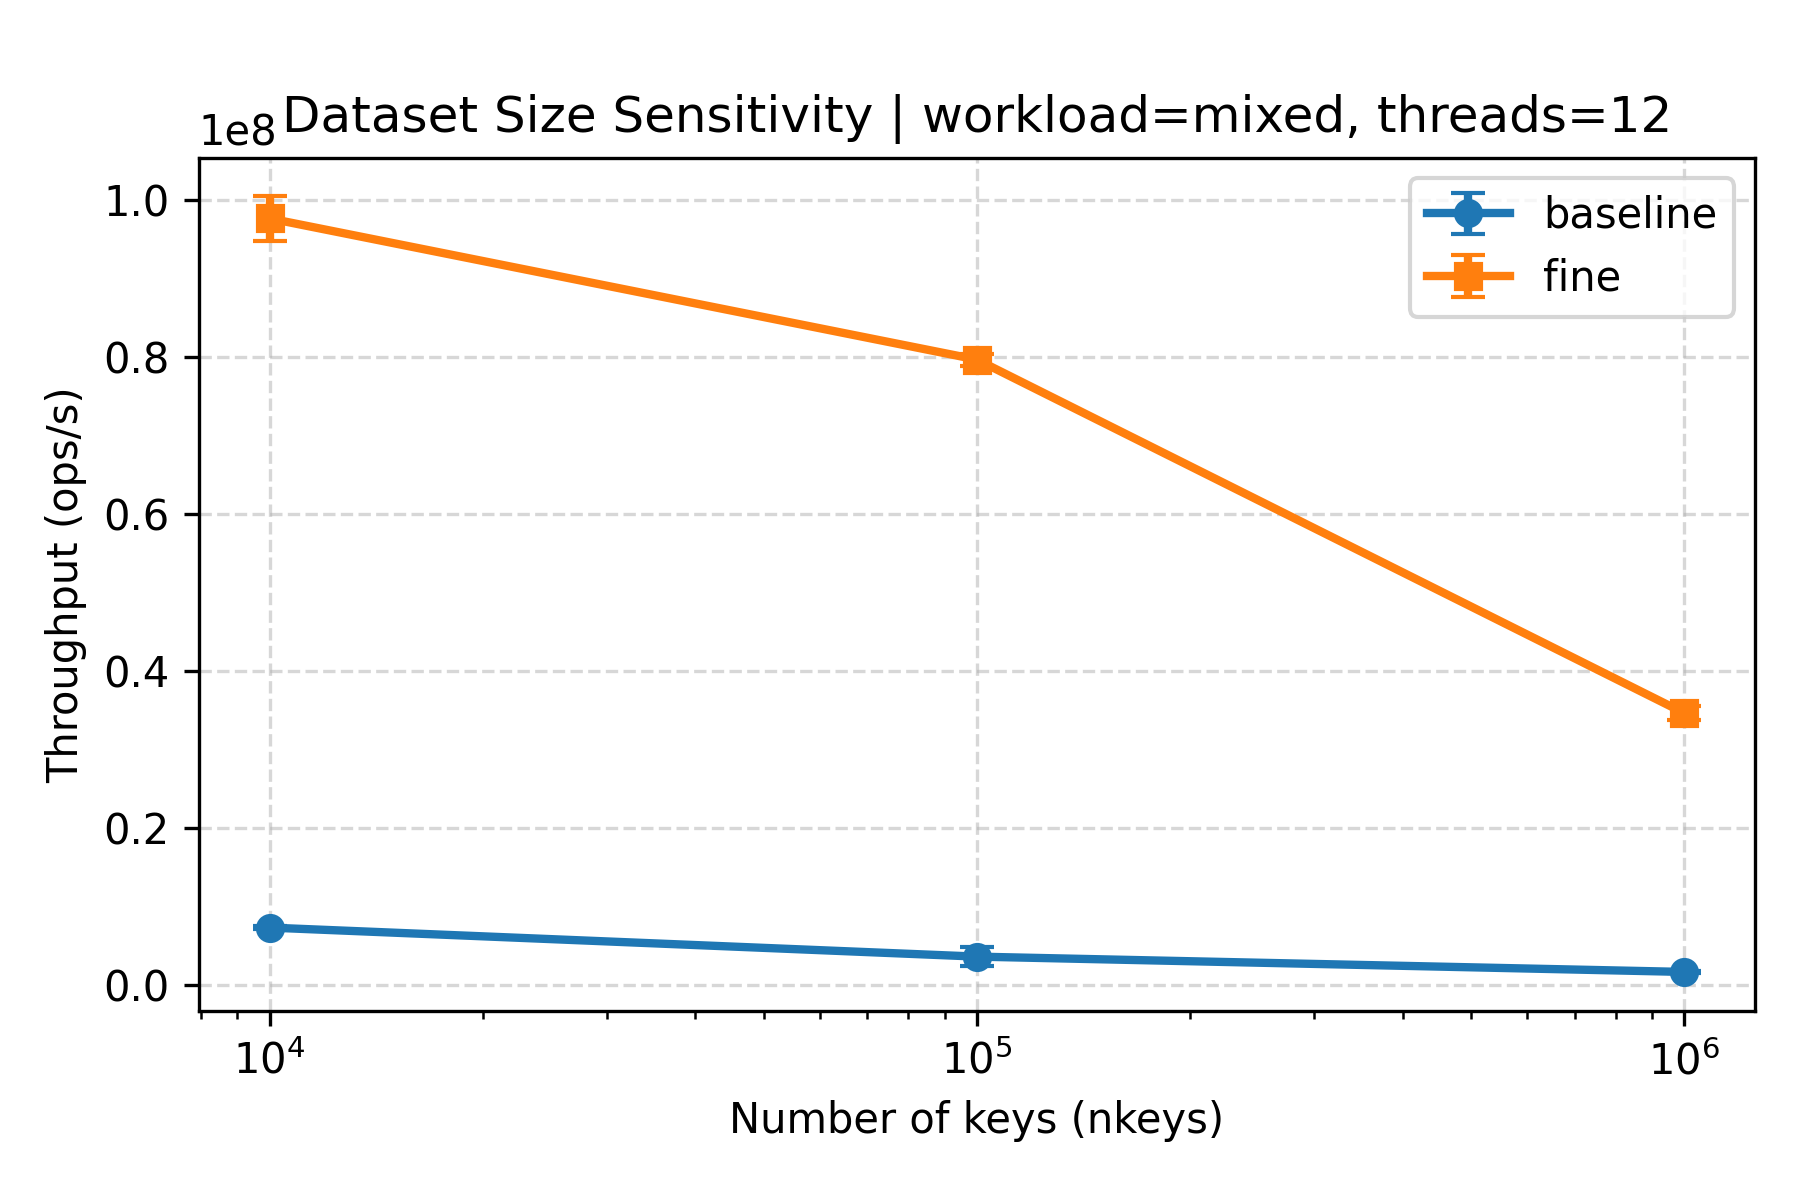|
|:----------------------------------------------------:|:----------------------------------:|:----------------------------------:|

Across all three workloads, throughput decreases as the dataset size grows from 1e4 to 1e6 keys. Since larger datasets increase bucket chain lengths and reduce cache locality, leading to more cache misses and higher memory access costs.

The coarse-grained baseline is consistently slow and becomes even worse as the dataset size increases. Larger datasets only amplify contention and memory overhead.

In contrast, the fine-grained locking design maintains a clear performance advantage at all dataset sizes, although its throughput also declines as nkeys increases. Fine-grained locking continues to scale much better than the baseline, showing that reducing lock granularity helps preserve performance under increasing memory pressure.

Overall, these results show that dataset size mainly affects cache efficiency, while synchronization design determines whether the system can still exploit parallelism as the workload scales.

## 3.3 Conclusion

**Amdahl’s Law & cache-coherence effects:**

In the coarse-grained baseline, almost the entire operation is protected by a single global lock, which effectively makes a large portion of the workload serial. According to Amdahl’s Law, this high serial fraction limits the maximum achievable speedup, so adding more threads provides little benefit and often increases contention.

In addition, the global lock causes frequent cache-line bouncing between cores, further amplifying synchronization overhead.

In contrast, the fine-grained locking design reduces the serial portion of the workload by distributing synchronization across independent buckets. Operations on different keys can proceed in parallel, increasing the effective parallel fraction and allowing speedup to scale with thread count. With less contention and reduced cache-coherence traffic, the fine-grained design is able to better utilize available cores, which explains its strong scalability across all workloads.

## 3.4 Limitation

Due to the use of a virtualized WSL environment, I can not get the results of load misses and cycles. As a result, the analysis of cache-coherence effects primarily relies on throughput/speedup measurements.